<a href="https://colab.research.google.com/github/Micah-Sanders/DATS6202/blob/dev_Micah/ML_Final_Mike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from gensim.parsing.preprocessing import remove_stopwords

# Load and preprocess Lightcast data
url = 'https://github.com/Micah-Sanders/DATS6202/raw/main/Lightcast.csv' #Set URL
lightcast_data = pd.read_csv(url) #Read in file from URL
lightcast_data = lightcast_data[['DESCRIPTION', 'CATEGORY']].dropna() #Drop missing data
lightcast_data['DESCRIPTION'] = lightcast_data['DESCRIPTION'].astype(str).apply(remove_stopwords) #Remove stop words

# Label encoding for categories and subcategories
category_encoder = LabelEncoder()
lightcast_data['CATEGORY_encoded'] = category_encoder.fit_transform(lightcast_data['CATEGORY'])
num_categories = lightcast_data['CATEGORY_encoded'].nunique()

In [ ]:
# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(lightcast_data, test_size=0.30, random_state=42)

# Text vectorization
vectorizer = TextVectorization(max_tokens=10000,
                               standardize="lower_and_strip_punctuation",
                               split="whitespace",
                               ngrams=None,
                               output_mode="int",
                               output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_data['DESCRIPTION']).batch(128)
vectorizer.adapt(text_ds)

# Training datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_data['DESCRIPTION'], train_data['CATEGORY_encoded'])).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((test_data['DESCRIPTION'], test_data['CATEGORY_encoded'])).batch(64)


In [ ]:
# Model definition
model = Sequential([
    vectorizer,
    Embedding(10000, 128, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dense(num_categories, activation='softmax', name='category_output')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 category_output (Dense)     (None, 30)                3870      
                                                                 
Total params: 1579934 (6.03 MB)
Trainable params: 157993

In [ ]:
# Model training
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

#Plot Accuracy vs. val_accuracy
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Loss vs. val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot All
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/10
93/93 [==============================] - 69s 644ms/step - loss: 1.8368 - accuracy: 0.4239 - val_loss: 1.3888 - val_accuracy: 0.5203
Epoch 2/10
93/93 [==============================] - 56s 601ms/step - loss: 1.3238 - accuracy: 0.5352 - val_loss: 1.3397 - val_accuracy: 0.5362
Epoch 3/10
93/93 [==============================] - 52s 557ms/step - loss: 1.0161 - accuracy: 0.6836 - val_loss: 1.4545 - val_accuracy: 0.5314
Epoch 4/10
93/93 [==============================] - 52s 562ms/step - loss: 0.7253 - accuracy: 0.7815 - val_loss: 1.5252 - val_accuracy: 0.5132
Epoch 5/10
93/93 [==============================] - 51s 547ms/step - loss: 0.5455 - accuracy: 0.8345 - val_loss: 1.6228 - val_accuracy: 0.5136
Epoch 6/10
93/93 [==============================] - 55s 594ms/step - loss: 0.4248 - accuracy: 0.8706 - val_loss: 2.1066 - val_accuracy: 0.5247
Epoch 7/10
93/93 [==============================] - 52s 556ms/step - loss: 0.3304 - accuracy: 0.8970 - val_loss: 2.3059 - val_accuracy: 0.5105

In [ ]:
# Evaluate the model on the test set
test_results = model.evaluate(val_ds)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")


40/40 [==============================] - 6s 158ms/step - loss: 3.0792 - accuracy: 0.5038
Test Accuracy: 50.38%


40/40 [==============================] - 10s 243ms/step


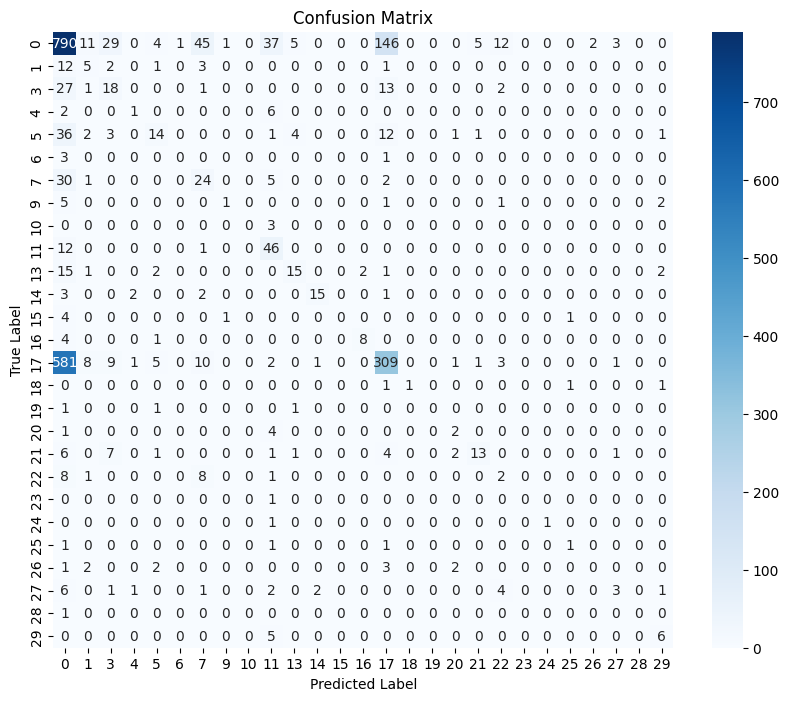

              precision    recall  f1-score   support

           0       0.51      0.72      0.60      1091
           1       0.16      0.21      0.18        24
           3       0.26      0.29      0.27        62
           4       0.20      0.11      0.14         9
           5       0.45      0.19      0.26        75
           6       0.00      0.00      0.00         4
           7       0.25      0.39      0.31        62
           9       0.33      0.10      0.15        10
          10       0.00      0.00      0.00         3
          11       0.40      0.78      0.53        59
          13       0.58      0.39      0.47        38
          14       0.83      0.65      0.73        23
          15       0.00      0.00      0.00         6
          16       0.80      0.62      0.70        13
          17       0.62      0.33      0.43       932
          18       1.00      0.25      0.40         4
          19       0.00      0.00      0.00         3
          20       0.25    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
# Predict categories on the test set for the confusion matrix
test_predictions = model.predict(val_ds)
test_predictions_indices = tf.argmax(test_predictions, axis=1).numpy()
true_labels = test_data['CATEGORY_encoded'].values

# Import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Find unique classes in true labels
unique_classes = np.unique(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_indices, labels=unique_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes) # Use unique_classes for labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report, using unique classes as target names
print(classification_report(true_labels, test_predictions_indices,
                            target_names=unique_classes.astype(str))) # Convert to strings for display

In [ ]:

# Load and preprocess the ESCO dataset
url2 = 'https://github.com/Micah-Sanders/DATS6202/raw/main/ESCO%20skills%20Taxonomy.csv'
esco_data = pd.read_csv(url2)
esco_data = esco_data[['description']].dropna()
esco_data['description'] = esco_data['description'].astype(str).apply(remove_stopwords)

# Prepare ESCO data for prediction
esco_ds = tf.data.Dataset.from_tensor_slices(esco_data['description']).batch(64)


In [ ]:
# Predict categories and subcategories using the trained model
predictions = model.predict(esco_ds)
predicted_categories_indices = tf.argmax(predictions, axis=1).numpy()



218/218 [==============================] - 39s 178ms/step


In [ ]:
# Convert category indices to category names
from sklearn.preprocessing import LabelEncoder
category_encoder = LabelEncoder()
predicted_categories = category_encoder.inverse_transform(predicted_categories_indices)

# Store the results back in DataFrame for further analysis or
import random
esco_data['Predicted_Category'] = predicted_categories
esco_data.to_csv('ESCO_with_Predicted_Categories.csv', index=False)
# Sample 50 rows from the DataFrame
sampled_data = esco_data.sample(n=50) # Sample from the DataFrame, not a list of it
sampled_data.to_csv('ESCO_with_Predicted_Categories_Sample_50.csv', index=True)

NameError: name 'predicted_categories_indices' is not defined